# 0. Import libraries

In [1]:
# Data wrangling 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# 1. Load data

Load the data that we have saved from the previous exercise. 

In [2]:
data = pd.read_pickle("C:/Users/Jason Chong/Documents/Forage ANZ/Data/data.pkl")
data.head()

,status,card_present_flag,account,long_lat,txn_description,merchant_id,first_name,balance,date,gender,...,extraction,amount,transaction_id,customer_id,merchant_long_lat,movement,month,dayofweek,hour,category
0,authorized,1,ACC-1598451071,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,Diana,35.39,2018-08-01,F,...,01:01:15,16.25,a623070bfead4541a6b0fff8a09e706c,CUS-2487424745,153.38 -27.99,debit,8,2,1,Purchase
1,authorized,0,ACC-1598451071,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,Diana,21.20,2018-08-01,F,...,01:13:45,14.19,13270a2a902145da9db4c951e04b51b9,CUS-2487424745,151.21 -33.87,debit,8,2,1,Purchase
2,authorized,1,ACC-1222300524,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,Michael,5.71,2018-08-01,M,...,01:26:15,6.42,feb79e7ecd7048a5a36ec889d1a94270,CUS-2142601169,151.21 -33.87,debit,8,2,1,Purchase
3,authorized,1,ACC-1037050564,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,Rhonda,2117.22,2018-08-01,F,...,01:38:45,40.90,2698170da3704fd981b15e64a006079e,CUS-1614226872,153.05 -26.68,debit,8,2,1,Purchase
4,authorized,1,ACC-1598451071,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,Diana,17.95,2018-08-01,F,...,01:51:15,3.25,329adf79878c4cf0aeb4188b4691c266,CUS-2487424745,153.44 -28.06,debit,8,2,1,Purchase


In [3]:
# Dataframe columns 
pd.DataFrame({"Columns": data.columns})

,Columns
0,status
1,card_present_flag
2,account
3,long_lat
4,txn_description
5,merchant_id
6,first_name
7,balance
8,date
9,gender


# 2. Feature engineering

In order to model annual salary, we first need to compute the annual salary for each customer as well as create features that can help us predict those salaries.

## 2.1 Target variable (customers' annual salary)

A target variable, or sometimes called a response variable, is the variable that we are trying to predict and in our case, this is the annual salary for each customer. 

In [4]:
# Check the salary payment frequency of each customer
salary_df = pd.DataFrame({"customer_id": data.customer_id.unique()})
salary_df.head()

,customer_id
0,CUS-2487424745
1,CUS-2142601169
2,CUS-1614226872
3,CUS-2688605418
4,CUS-4123612273


In [5]:
example = data.loc[(data.customer_id == salary_df.customer_id[0]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
example

,date,amount
0,2018-08-01,1013.67
1,2018-08-08,1013.67
2,2018-08-15,1013.67
3,2018-08-22,1013.67
4,2018-08-29,1013.67
5,2018-09-05,1013.67
6,2018-09-12,1013.67
7,2018-09-19,1013.67
8,2018-09-26,1013.67
9,2018-10-03,1013.67


In [6]:
# Loop through all salary payments for each customer
# Assume the salary level is constant for each customer over the observed period
df_freq = []
df_amount = []

for customer in range(len(salary_df)):
    salary = data.loc[(data.customer_id == salary_df.customer_id[customer]) & (data.txn_description == "PAY/SALARY"), ["date", "amount"]].groupby("date", as_index = False).sum()
    count = len(salary)
    if count == 0:
        df_amount.append(np.nan)
        df_freq.append(np.nan)
    else:
        days_between_payments = []
        for date in range(len(salary)-1):
            days_between_payments.append((salary.date[date + 1] - salary.date[date]).days)
        df_freq.append(max(days_between_payments))
        df_amount.append(mode(salary.amount))

salary_df["salary_freq"] = df_freq
salary_df["salary_amount"] = df_amount       
salary_df["annual_salary"] = salary_df["salary_amount"] / salary_df["salary_freq"] * 365.25
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


There were multiple mode values for days_between_payments, so I decided to take the maximum.

Text(0.5, 0, 'Annual salary')

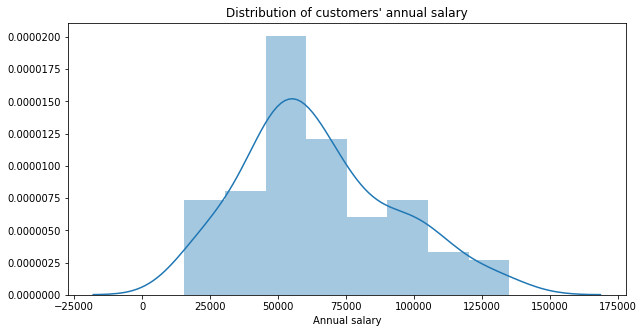

In [7]:
# Plot customer's annual salary distribution 
plt.figure(figsize = (10, 5))
sns.distplot(salary_df.annual_salary)
plt.title("Distribution of customers' annual salary")
plt.xlabel("Annual salary")

# 2.2 Predictor variables

Predictor variables or features are variables that will help us predict the salaries for each customer. 

In this section, we will create the following features each customer:
- Average number of weekly transactions
- Maximum transaction amount
- Number of large transactions (over $100)
- Number of days with transactions
- Average transaction amount
- Median balance
- State of residence

By no means this is an exhaustive list of features we can create. Feel free to come up with your own features!

Also, not to forget from our original dataframe:
- Age
- Gender

In [8]:
# Unique customer id's 
unique_id = data.customer_id.unique()
len(unique_id)

100

In [9]:
unique_id[:5]

array(['CUS-2487424745', 'CUS-2142601169', 'CUS-1614226872',
       'CUS-2688605418', 'CUS-4123612273'], dtype=object)

## 2.2.1 Average number of weekly transactions

In [10]:
avg_no_weekly_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    avg_no_weekly_trans.append(round(len(array)/array.nunique()*7))
avg_no_weekly_trans[:5]

[48, 29, 24, 14, 21]

## 2.2.2 Maximum amount 

In [11]:
max_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    max_amount.append(max(array))
max_amount[:5]

[1452.21, 2349.55, 892.09, 2320.3, 1068.04]

## 2.2.3 Number of large transactions (over $100)

In [12]:
no_large_trans = []
for id_ in unique_id:
    count = 0
    array = data.loc[data.customer_id == id_, "amount"]
    for amount in array:
        if amount > 100:
            count += 1
    no_large_trans.append(count)
no_large_trans[:5]

[22, 23, 22, 25, 32]

## 2.2.4 Number of days with transactions 

In [13]:
no_days_with_trans = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "date"]
    no_days_with_trans.append(array.nunique())
no_days_with_trans[:5]

[85, 74, 76, 63, 44]

## 2.2.5 Average transaction amount 

In [14]:
avg_trans_amount = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "amount"]
    avg_trans_amount.append(array.mean())
avg_trans_amount[:5]

[45.34877162629756,
 78.20610561056101,
 74.46501930501928,
 159.3041860465116,
 166.50835820895517]

## 2.2.6 Median balance

In [15]:
median_balance = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "balance"]
    median_balance.append(array.median())
median_balance[:5]

[1580.4, 1132.66, 3618.5, 5616.63, 6162.45]

## 2.2.7 State of residence 

In [16]:
# Assume customers live in the state where most of their transactions occured
state = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "merchant_state"]
    state.append(mode(array))
state[:5]

['QLD', 'NSW', 'QLD', 'NSW', 'VIC']

## 2.2.8 Include age and gender from original dataframe

In [17]:
age = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "age"]
    age.append(mode(array))
age[:5]

[26, 38, 40, 20, 43]

In [18]:
gender = []
for id_ in unique_id:
    array = data.loc[data.customer_id == id_, "gender"]
    gender.append(mode(array))
gender[:5]

['F', 'M', 'F', 'M', 'F']

## 2.2.9 Putting everything together 

Here, we will put together all the features that we have created into a dataframe called features_df and subsequently concatenate the annual salary for each customer to form a final dataframe called df. 

In [19]:
# Predictor variables 
features_df = pd.DataFrame({"customer_id": unique_id, 
                            "avg_no_weekly_trans": avg_no_weekly_trans, 
                            "max_amount": max_amount, 
                            "no_large_trans": no_large_trans,
                            "avg_trans_amount": avg_trans_amount,
                            "median_balance": median_balance, 
                            "state": state,
                            "age": age,
                            "gender": gender})
features_df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F


In [20]:
# Target variable 
salary_df.head()

,customer_id,salary_freq,salary_amount,annual_salary
0,CUS-2487424745,7,1013.67,52891.852500
1,CUS-2142601169,7,1002.13,52289.711786
2,CUS-1614226872,7,892.09,46547.981786
3,CUS-2688605418,14,2320.30,60534.969643
4,CUS-4123612273,7,1068.04,55728.801429


In [21]:
# Concat annual salary column to features dataframe  
df = pd.concat([features_df, salary_df.annual_salary], axis = 1)
df.head()

,customer_id,avg_no_weekly_trans,max_amount,no_large_trans,avg_trans_amount,median_balance,state,age,gender,annual_salary
0,CUS-2487424745,48,1452.21,22,45.348772,1580.40,QLD,26,F,52891.852500
1,CUS-2142601169,29,2349.55,23,78.206106,1132.66,NSW,38,M,52289.711786
2,CUS-1614226872,24,892.09,22,74.465019,3618.50,QLD,40,F,46547.981786
3,CUS-2688605418,14,2320.30,25,159.304186,5616.63,NSW,20,M,60534.969643
4,CUS-4123612273,21,1068.04,32,166.508358,6162.45,VIC,43,F,55728.801429


In [22]:
# Check for missing values 
df.isnull().sum()

customer_id            0
avg_no_weekly_trans    0
max_amount             0
no_large_trans         0
avg_trans_amount       0
median_balance         0
state                  0
age                    0
gender                 0
annual_salary          0
dtype: int64

Great, there are no missing values!

Our final dataframe is now ready for some minor preprocessing and then we are good to go with modelling. 

# 3. Preprocessing

In this section, we will perform train and test split on our final dataframe as well as construct a column transformer which consists of one-hot-encoder and standard scaler. 

## 3.1 Train test split

Here, we will split 70% of the dataframe into training set, which is used to train our model and 30% of the dataframe into test set, which is used to assess model predictions.

In [23]:
X = df.drop(["customer_id", "annual_salary"], axis = 1)
Y = df.annual_salary
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

X shape:  (100, 8)
Y shape:  (100,)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (70, 8)
Y_train shape:  (70,)
X_test shape:  (30, 8)
Y_test shape:  (30,)


## 3.2 Column transformer with one-hot encoder and standard scaler

Models cannot train on variables that contain text, therefore we need to encode both the state and gender columns using one-hot encoder. Furthermore, to ensure that each feature contributes proportionally to the final prediction, we need to scale all the numerical variables using standard scaler.

We will include both the one-hot encoder and the standard scaler into a single column transformer. 

In [25]:
# Crete column transformer 
ohe = OneHotEncoder(sparse = False)
scaler = StandardScaler()
column_transform = make_column_transformer((ohe, ["state", "gender"]), (scaler, ["avg_no_weekly_trans", "max_amount", "no_large_trans", "avg_trans_amount", "median_balance", "age"]))

# 4. Predict customers' annual salary

Now that our column transformer is ready, we can build a pipeline using the column transformer and a machine learning model to predict customers' annual salary. 

Here, we will try two models:
- Linear regression
- Decision tree regressor 

## 4.1 Linear regression

In [26]:
# Instantiate model and pipeline
lm = LinearRegression()
lm_pipeline = make_pipeline(column_transform, lm)

In [27]:
# Fit pipeline and make predictions 
lm_pipeline.fit(X_train, Y_train)
lm_pred = lm_pipeline.predict(X_test)

In [28]:
# RMSE
print("RMSE: ", round(np.sqrt(mean_squared_error(lm_pred, Y_test))))

RMSE:  27836.0


## 4.2 Decision tree 

In [29]:
# Instantiate model and pipeline 
tree = DecisionTreeRegressor()
tree_pipeline = make_pipeline(column_transform, tree)

In [30]:
# Fit pipeline and make predictions 
tree_pipeline.fit(X_train, Y_train)
tree_pred = tree_pipeline.predict(X_test)

In [31]:
# RMSE 
print("RMSE: ", round(np.sqrt(mean_squared_error(tree_pred, Y_test))))

RMSE:  20101.0


# 5. Conclusion 

The RMSE for both models are over $20,000 and although decision tree performed better than linear regression by having a smaller RMSE, both models still appear to be highly inaccurate. Therefore, it is risky to use them to predict customers' income bracket. More data is required to develop a more reliable model. 

Nevertheless, one can invest more time into coming up with more features and selecting the best ones using backward elimination by optimising for a specific metric like AIC, however I doubt the result will be materially different as we only have a very limited amount of data (100 salaries) available. 